In [20]:
# Load Data
import pandas as pd
data = pd.read_csv('isc_data.csv')

In [21]:
# Getting treated cases
treated = data[data.ever_carer]
len(treated.pidp.unique())

648

In [22]:
# Get controls cases
controls = data[~data.ever_carer]
len(controls.pidp.unique())

12328

In [23]:
def get_control_clean(c_data, t_data):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        init = t_data[t_data.pidp == t_id].initial_wave.unique()[0]
        treat_time = t_data[t_data.pidp == t_id].wave_treat_real.unique()[0]
        last_wave = t_data[t_data.pidp == t_id].wave.max()
        length = (last_wave + 1) - init
        # HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
        idx = c_data[(c_data.wave >= init) & (controls.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
        sub_sample = c_data[(c_data.wave >= init) & (c_data.wave <= last_wave)][idx].reset_index(drop=True)
        treat = t_data[t_data.pidp == t_id].pivot(index='wave', columns='pidp', values='wage_h_deflated')
        #treat.columns = ['treated']
        sub_sample = sub_sample.pivot(index='wave', columns='pidp', values='wage_h_deflated')
        sub_sample = pd.concat([treat, sub_sample], axis=1, join="inner")
        out['data'] = sub_sample
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [24]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in carers.pidp:
    idx.append(is_consecutive(carers[carers.pidp == pidp].wave))

In [25]:
samples = get_control_clean(controls, carers[idx])

In [62]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from multiprocessing import Pool

def create_index(x):
    y = np.arange(len(x)) + 1
    return y - x

def create_relative_index(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]


# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))


# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x

def sc(x):
    data = x['data'].copy()
    t_time = x['treat_time']
    data.sort_index(inplace=True)
    data.index = create_relative_index(data.index.tolist(), t_time)
    df_T0 = data.loc[:-1, :] # this needs to be revised
    Y_0 = df_T0.iloc[:, 0].values
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=300, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0]
    diff = treated - synth
    std_diff = (diff - diff.mean())/ diff.std()
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff,
        'std_diff': std_diff
    }


def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    with Pool() as p:
        out = p.map(sc, data_objects)
    for ele in out:
        synths.append(ele['synth'])
        treats.append(ele['treated'])
        diffs.append(ele['diff'])
        std_diffs.append(ele['std_diff'])
    return {'synths': synths,
            'treats': treats,
            'diffs': diffs,
            'std_diffs': std_diffs}


In [63]:
out = isc(samples)

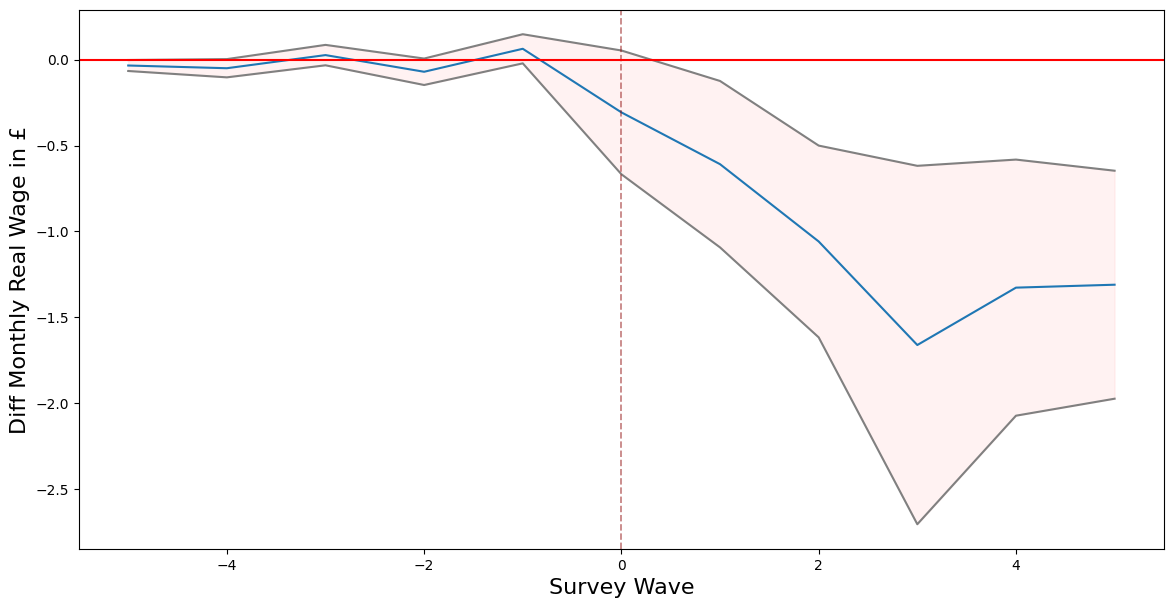

In [64]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()
differences.loc[-5:5].mean(axis=1).plot()
(differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Survey Wave', fontsize=16)
plt.ylabel('Diff Monthly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.loc[-5:5].index,
                 y1=differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                 y2=differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()